# DL development pipeline

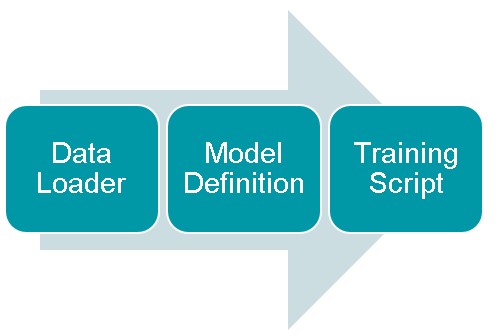

```
# Example from https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class CIFAR10Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
```



*   `__len__` : Number of batch in the Sequence.
*   `__getitem__` : Returns a complete batch.
*   `on_epoch_end` (optional) : Modifies dataset between epochs.





In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, 
                 fold, image_size, mode='train',
                 shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
csv_path = '/content/drive/MyDrive/data/kfolds.csv'

train_generator = DataGenerator(
    batch_size=9, 
    csv_path=csv_path,
    fold=1,
    image_size=256,
    mode='train',
    shuffle=True
)

In [5]:
print(len(train_generator))

654


In [6]:
(654 * 9)

5886

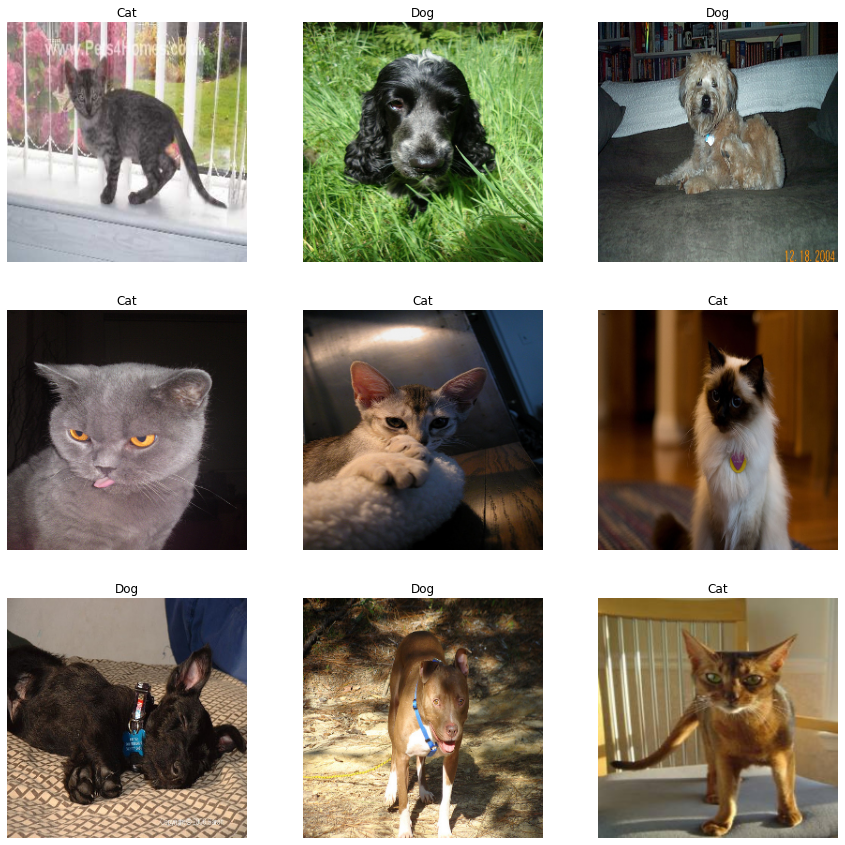

In [7]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    
    break